In [66]:
%%bash

pip install tqdm

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

import time
from tqdm import tqdm


import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [27]:
def get_best_ranks(ranks, top):
    idx = np.argpartition(ranks, top, axis = 1 )[:,:top]
    return idx
    


def maxnum(y):
    ind = np.unique(y,return_counts = True, return_inverse = True)
    return ind[0][np.argmax(ind[2])]


class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric = 'euclidean'):
        self.metric = metric
        self.n = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        self.y = y
        self.Xtr = X
    
    def predict(self, X):
        self.Xtes = X
        if self.algorithm == 'brute':
            if self.metric == 'euclidean':
                self.dist = distance.cdist(self.Xtes,self.Xtr)
            elif self.metric == 'cosine':
                self.dist = distance.cdist(self.Xtes,self.Xtr, metric = 'cosine')
            self.ranks = get_best_ranks(self.dist, self.n)
            self.pair_predict = np.take_along_axis(self.y.reshape(1,-1) + np.zeros(len(self.Xtes)).reshape(-1,1), self.ranks, axis = 1).astype(int)
            return np.apply_along_axis(maxnum, 1, self.pair_predict)
        elif self.algorithm == 'kd_tree':
            self.tree = KDTree(self.Xtr)
            self.dist = self.tree.query(self.Xtes, self.n, return_distance = True)[1]
            self.pair_predict = np.take_along_axis(self.y.reshape(1,-1) + np.zeros(len(self.Xtes)).reshape(-1,1), self.dist, axis = 1).astype(int)
            return np.apply_along_axis(maxnum, 1, self.pair_predict)
        
     

In [28]:
(my_clf.predict(X_test))

array([2, 1, 0, 0, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1, 1])

In [88]:
X_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.10791692,
        0.15625918],
       [0.        , 0.        , 0.04927727, ..., 0.        , 0.0381422 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14065107,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.13213564,
        0.        ]])

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [29]:
iris = datasets.load_iris()

In [92]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
X_train = (X_train - np.mean(X_train, axis = 0))/ np.std(X_train, axis = 0)
X_test = (X_test - np.mean(X_test, axis = 0))/ np.std(X_test, axis = 0)

In [93]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [94]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [95]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [35]:
%time clf.fit(X_train, y_train)

CPU times: user 559 µs, sys: 138 µs, total: 697 µs
Wall time: 581 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [36]:
%time my_clf.fit(X_train, y_train)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 13.1 µs


In [37]:
%time clf.predict(X_test)

CPU times: user 4.81 ms, sys: 4.6 ms, total: 9.41 ms
Wall time: 7.56 ms


array([0, 2, 1, 1, 1, 0, 0, 0, 2, 1, 2, 2, 1, 0, 1])

In [38]:
%time my_clf.predict(X_test)

CPU times: user 2.67 ms, sys: 1.72 ms, total: 4.38 ms
Wall time: 2.82 ms


array([0, 2, 1, 1, 1, 0, 0, 0, 2, 1, 2, 2, 1, 0, 1])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [39]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [41]:
%time clf.fit(X_train, y_train)

CPU times: user 1.88 ms, sys: 1.91 ms, total: 3.79 ms
Wall time: 4.42 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [49]:
%time my_clf.fit(X_train, y_train)

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 13.1 µs


In [43]:
%time clf.predict(X_test)

CPU times: user 2.7 ms, sys: 1.64 ms, total: 4.34 ms
Wall time: 3.24 ms


array([0, 2, 1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 1])

In [46]:
%time my_clf.predict(X_test)

CPU times: user 2.64 ms, sys: 1.86 ms, total: 4.5 ms
Wall time: 3 ms


array([0, 2, 1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 1])

In [50]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [51]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [53]:
data = newsgroups['data']
target = newsgroups['target']
target

array([7, 4, 4, ..., 3, 1, 8])

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [56]:
vtext = CountVectorizer(min_df = 0.03, max_df = 0.8)
vmas = vtext.fit_transform(data)
newdat = vmas.toarray()
newdat.shape

(11314, 407)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [105]:
folds_ind = KFold(n_splits = 3, shuffle = True)


(7542, 3772)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [99]:
def get_best_n(newdat, target):
    results_euclidian = list()
    for j in tqdm(range(1, 11)):
        res = list()
        folds_ind = KFold(n_splits = 3, shuffle = True)
        for train_index, test_index in folds_ind.split(target):
            X_train  = newdat[train_index]
            X_test  = newdat[test_index]
            X_train = (X_train - np.mean(X_train, axis = 0))/ np.std(X_train, axis = 0)
            X_test = (X_test - np.mean(X_test, axis = 0))/ np.std(X_test, axis = 0)
            Y_train = target[train_index]
            Y_test  = target[test_index]
            my_clf = MyKNeighborsClassifier(n_neighbors = j, algorithm = 'brute')
            my_clf.fit(X_train,Y_train)
            res.append(accuracy_score(my_clf.predict(X_test),Y_test))
        results_euclidian.append(np.mean(np.asarray(res)))
        res.clear()
        print("#" + str(j))
    return (np.argmax(results_euclidian)+1, results_euclidian)

best_res, results_eu = get_best_n(newdat, target)

 10%|████▍                                       | 1/10 [00:16<02:24, 16.08s/it]

#1


 20%|████████▊                                   | 2/10 [00:31<02:06, 15.85s/it]

#2


 30%|█████████████▏                              | 3/10 [00:47<01:51, 15.98s/it]

#3


 40%|█████████████████▌                          | 4/10 [01:04<01:37, 16.27s/it]

#4


 50%|██████████████████████                      | 5/10 [01:20<01:21, 16.27s/it]

#5


 60%|██████████████████████████▍                 | 6/10 [01:38<01:07, 16.76s/it]

#6


 70%|██████████████████████████████▊             | 7/10 [01:56<00:51, 17.20s/it]

#7


 80%|███████████████████████████████████▏        | 8/10 [02:13<00:34, 17.04s/it]

#8


 90%|███████████████████████████████████████▌    | 9/10 [02:30<00:16, 16.97s/it]

#9


100%|███████████████████████████████████████████| 10/10 [02:46<00:00, 16.66s/it]

#10


The best number of neighbours is 1


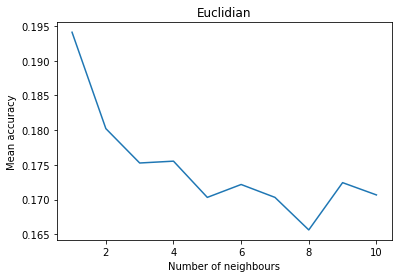

In [100]:
print(f"The best number of neighbours is {best_res}")
fig = plt.figure()
graph = fig.add_subplot(111)
plt.plot(range(1,11), results_eu)
plt.xlabel("Number of neighbours")
plt.ylabel("Mean accuracy")
plt.title("Euclidian")
plt.show()

In [98]:
len(results)


25

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [107]:
vtext = TfidfVectorizer(min_df = 0.05, max_df = 0.9)
vmas = vtext.fit_transform(data)
newdat = vmas.toarray()
folds_ind = KFold(n_splits = 3, shuffle = True)


#metric = euclidean or cosine

def get_best_n(newdat, target, metric = 'euclidean'):
    results_euclidian = list()
    for j in tqdm(range(1, 11)):
        res = list()
        folds_ind = KFold(n_splits = 3, shuffle = True)
        for train_index, test_index in folds_ind.split(target):
            X_train  = newdat[train_index]
            X_test  = newdat[test_index]
            X_train = (X_train - np.mean(X_train, axis = 0))/ np.std(X_train, axis = 0)
            X_test = (X_test - np.mean(X_test, axis = 0))/ np.std(X_test, axis = 0)
            Y_train = target[train_index]
            Y_test  = target[test_index]
            my_clf = MyKNeighborsClassifier(n_neighbors = j, algorithm = 'brute', metric = metric)
            my_clf.fit(X_train,Y_train)
            res.append(accuracy_score(my_clf.predict(X_test),Y_test))
        results_euclidian.append(np.mean(np.asarray(res)))
        res.clear()
        print("#" + str(j))
    return (np.argmax(results_euclidian)+1, results_euclidian)

best_res_cos, results_cos = get_best_n(newdat, target, 'cosine')

 10%|████▍                                       | 1/10 [00:31<04:44, 31.56s/it]

#1


 20%|████████▊                                   | 2/10 [01:03<04:16, 32.02s/it]

#2


 30%|█████████████▏                              | 3/10 [01:36<03:46, 32.31s/it]

#3


 40%|█████████████████▌                          | 4/10 [02:08<03:12, 32.10s/it]

#4


 50%|██████████████████████                      | 5/10 [02:40<02:40, 32.15s/it]

#5


 60%|██████████████████████████▍                 | 6/10 [03:13<02:09, 32.30s/it]

#6


 70%|██████████████████████████████▊             | 7/10 [03:45<01:36, 32.28s/it]

#7


 80%|███████████████████████████████████▏        | 8/10 [04:20<01:06, 33.31s/it]

#8


 90%|███████████████████████████████████████▌    | 9/10 [04:53<00:33, 33.14s/it]

#9


100%|███████████████████████████████████████████| 10/10 [05:26<00:00, 32.62s/it]

#10


The best number of neighbours for euclidian metric is 1
The best number of neighbours for cosine metric is 10


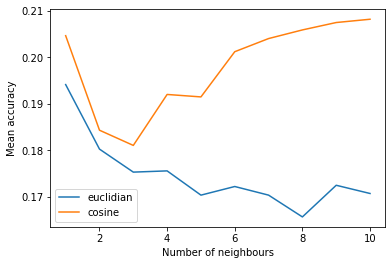

In [108]:
print(f"The best number of neighbours for euclidian metric is {best_res}")
print(f"The best number of neighbours for cosine metric is {best_res_cos}")
fig = plt.figure()
plt.plot(range(1,11), results_eu, label="euclidian")
plt.plot(range(1,11), results_cos, label="cosine")
plt.xlabel("Number of neighbours")
plt.ylabel("Mean accuracy")
plt.legend()
plt.show()

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [81]:
tnewsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [82]:
vtext = CountVectorizer(min_df = 0.03, max_df = 0.8)
vmas = vtext.fit_transform(tnewsgroups)
newdattest = vmas.toarray()
newdattest.shape

(5, 5)

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

Лучшая модель по точности  -  модель с TfIdf векторизацией и косинусной метрикой!

In [131]:
len(newsgroups['data']), len(tnewsgroups['data'])



(7532, 7532)

In [128]:
nnewsgroups = tnewsgroups['data']+ newsgroups['data']
len(nnewsgroups)


15064

In [130]:
vtext = TfidfVectorizer(min_df = 0.05, max_df = 0.9)
vmas = vtext.fit_transform(nnewsgroups)
nnewdat = vmas.toarray()
nnewdat.shape

(15064, 227)

In [132]:
train_X, test_X = nnewdat[:-7532], nnewdat[-7532:]

In [133]:
my_clf = MyKNeighborsClassifier(n_neighbors = 10, algorithm = 'brute', metric = 'cosine')
my_clf.fit(train_X, target)
accuracy_score(my_clf.predict(test_X), tnewsgroups['target'])

0.05403611258629846

Точность оказалась почти в 4 раза хуже, чем при кросс-валидации. 
Причины:
1) Размер выборки до этого был сильно меньше, чем сейчас
2) Обучались на одний данных, а тестировались на других